In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import statsmodels.graphics.tsaplots as sgt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, LSTM, Dropout
from keras import regularizers, optimizers
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import root_mean_squared_error

In [3]:
# fix random seed for reproducibility
tf.random.set_seed(7)

In [4]:
# after tuning, set True to avoid re-running the process
have_best_model = True

### 1.1 Data: Loading and preprocessing

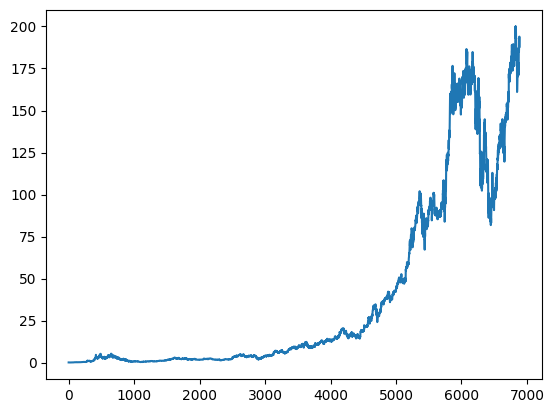

In [5]:
# dataframe = pd.read_excel('../Data.xlsx')['N_TOTAL_BAL_EOD']
dataframe = pd.read_csv('dataset/AMZN_daily_data.csv', usecols=[5], engine='python')#.iloc[:-2000, :]
dataset = dataframe.values
dataset = dataset.astype('float32')
plt.plot(dataset)
plt.show()

In [6]:
OOT_steps = int(dataframe.shape[0] / 5)

In [7]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset.reshape(-1, 1))

### 1.2 Data: Train-test split

In [8]:
# split into train and test sets
sigma = 0.67
train_size = int(len(dataset) * sigma)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

4614 2274


### 1.3 Data: Creating dataset

For each (X,Y) pair, take n periods from the data (look_back=n) to create variable X (predictor) and the subsequent period as variable Y.

Note: look_back is a parameter of dimensionality of the dataset, not a hyperparameter related to the model. Therefore, it is not to be tuned but set with respect to the purpose/meaning of using the LSTM model.

In [9]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

In [10]:
# reshape into X=t and Y=t+1
look_back = 15
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [11]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

### 2.1 Model: Setting up

In [12]:
# Function to create the Keras model with hyperparameters
def create_model(look_back=1, lstm_units=8, number_of_layers=2, learning_rate=0.01, optimizer='adam'):
    model = Sequential()
    # Define the input shape with an Input layer
    model.add(Input(shape=(1, look_back)))
    for i in range(number_of_layers):
       if i == number_of_layers - 1:
           # Last LSTM layer does not return sequences
           model.add(LSTM(lstm_units, kernel_regularizer=regularizers.L2(5e-3)))
           model.add(Dropout(0,3))
       else:
           # Intermediate LSTM layers return sequences
           model.add(LSTM(lstm_units, kernel_regularizer=regularizers.L2(5e-3), return_sequences=True))
           model.add(Dropout(0,3))
    model.add(Dense(1))  # Output layer for regression
    if optimizer == 'adam':
        model.compile(loss='mean_squared_error', optimizer=optimizers.Adam(learning_rate=learning_rate))
    elif optimizer == 'sgd':
        model.compile(loss='mean_squared_error', optimizer=optimizers.SGD(learning_rate=learning_rate))
    elif optimizer == 'rmsprop':
        model.compile(loss='mean_squared_error', optimizer=optimizers.RMSprop(learning_rate=learning_rate))
    return model

### 2.2 Model: Fitting & Tuning with Bayesian optimization

In [13]:
# Best: -0.000263 using OrderedDict([('batch_size', 459),
                                #    ('epochs', 200), 
                                #    ('learning_rate', 0.0072328845978307495), 
                                #    ('lstm_units', 4), 
                                #    ('number_of_layers', 1), 
                                #    ('optimizer', 'rmsprop')])

In [14]:
if have_best_model:
    best_model = create_model(look_back=look_back, lstm_units=14, number_of_layers=1, learning_rate=0.001, optimizer='rmsprop')
    best_model.fit(trainX, trainY, epochs=70, batch_size=6, verbose=2)
    
else:
    from scikeras.wrappers import KerasRegressor
    from skopt import BayesSearchCV
    from skopt.space import Real, Integer, Categorical

    # Wrap the model with KerasRegressor
    model = KerasRegressor(model=create_model, look_back=look_back, lstm_units=4,
                           number_of_layers=2, learning_rate=0.01, optimizer='adam',
                           verbose=1
                           )

    # Define the hyperparameter space boundaries, dimensions include
    # LSTM units, # of layers, learning rate, # of epochs, batch size and optimizer
    search_space = {
        'lstm_units': Integer(4, 16),
        'number_of_layers': Integer(1, 4),
        'learning_rate': Real(1e-5, 1e-1, prior='log-uniform'),
        'epochs': Integer(50, 200),
        'batch_size': Integer(1, trainX.shape[0] // 10),
        'optimizer': Categorical(['adam', 'sgd', 'rmsprop']),
    }

    # BayesSearchCV search optimization configuration
    bayes_search = BayesSearchCV(estimator=model,
        search_spaces=search_space,
        n_iter=32,  # Number of iterations to perform
        cv=3,
        scoring='neg_mean_squared_error',
        random_state=64
        )

    # Fit and tune
    bayes_result = bayes_search.fit(trainX, trainY)

    print("Best: %f using %s" % (bayes_result.best_score_, bayes_result.best_params_))

    # Best model
    best_model = bayes_result.best_estimator_.model_

Epoch 1/70
767/767 - 2s - 2ms/step - loss: 0.0110
Epoch 2/70
767/767 - 1s - 1ms/step - loss: 5.3171e-04
Epoch 3/70
767/767 - 1s - 1ms/step - loss: 4.1524e-04
Epoch 4/70
767/767 - 1s - 1ms/step - loss: 3.2275e-04
Epoch 5/70
767/767 - 1s - 1ms/step - loss: 2.5639e-04
Epoch 6/70
767/767 - 1s - 1ms/step - loss: 2.1016e-04
Epoch 7/70
767/767 - 1s - 1ms/step - loss: 1.7769e-04
Epoch 8/70
767/767 - 1s - 1ms/step - loss: 1.5433e-04
Epoch 9/70
767/767 - 1s - 1ms/step - loss: 1.3704e-04
Epoch 10/70
767/767 - 1s - 1ms/step - loss: 1.2390e-04
Epoch 11/70
767/767 - 1s - 1ms/step - loss: 1.1366e-04
Epoch 12/70
767/767 - 1s - 1ms/step - loss: 1.0551e-04
Epoch 13/70
767/767 - 1s - 1ms/step - loss: 9.8896e-05
Epoch 14/70
767/767 - 1s - 1ms/step - loss: 9.3384e-05
Epoch 15/70
767/767 - 1s - 1ms/step - loss: 8.8863e-05
Epoch 16/70
767/767 - 1s - 1ms/step - loss: 8.5137e-05
Epoch 17/70
767/767 - 1s - 1ms/step - loss: 8.1907e-05
Epoch 18/70
767/767 - 1s - 1ms/step - loss: 7.9295e-05
Epoch 19/70
767/767 - 1

### 3.1 Validation: Applying on testing set & OOT

In [ ]:
# make predictions
trainPredict = best_model.predict(trainX)
testPredict = best_model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY_ = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY_ = scaler.inverse_transform([testY])
# calculate mean absolute percentage error
trainScore = np.mean(np.abs((trainY_[0] - trainPredict[:,0]) / trainY_[0])) * 100
print('Train Score: %.2f MAPE' % (trainScore))
testScore = np.mean(np.abs((testY_[0] - testPredict[:,0]) / testY_[0])) * 100
print('Test Score: %.2f MAPE' % (testScore))

144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 758us/step
Train Score: 37.22 MAPE
Test Score: 3.53 MAPE


In [16]:
# calculate root mean squared error
trainScore = root_mean_squared_error(trainY_[0], trainPredict[:,0])
print('Train Score: %.2f RMSE' % (trainScore))
testScore = root_mean_squared_error(testY_[0], testPredict[:,0])
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.63 RMSE
Test Score: 5.41 RMSE


In [17]:
last_sequence = testX[-1].reshape(1, look_back)

# Prepare a list to hold predictions
forecast = []

for step in range(OOT_steps):
    # The model expects input shape (samples, timesteps, features)
    # Here, timesteps is 1 (each sequence is treated as a single time step with 'look_back' features)
    input_seq = last_sequence.reshape(1, 1, look_back)
    pred = best_model.predict(input_seq, verbose=0)
    
    # Save the prediction (a single value)
    forecast.append(pred[0, 0])
    
    # Update the last_sequence by appending the prediction and dropping the first value.
    # This creates a new sequence for the next forecast step.
    last_sequence = np.roll(last_sequence, -1)
    last_sequence[0, -1] = pred[0, 0]

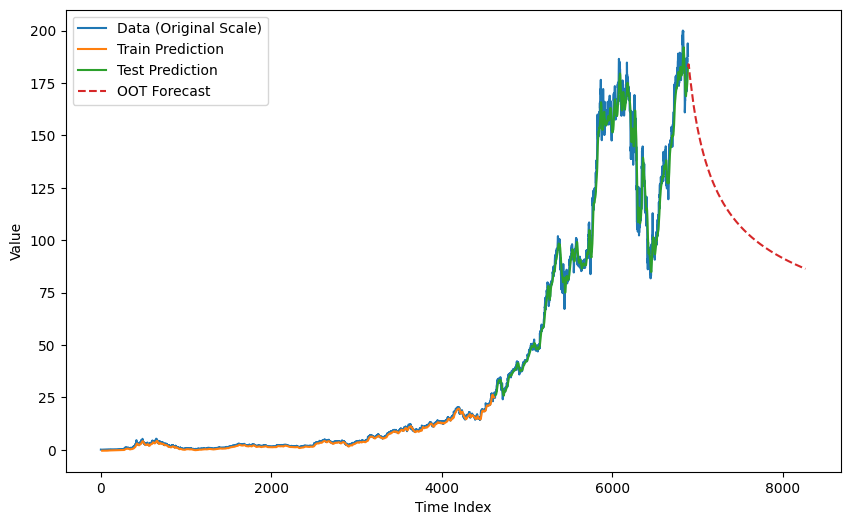

In [18]:
# === Shift train predictions for plotting ===
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict) + look_back, :] = trainPredict
# === Shift test predictions for plotting ===
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict) + (look_back * 2) + 1:len(dataset) - 1, :] = testPredict
# === Create an extended dataset to include OOT forecast ===
extended_length = dataset.shape[0] + OOT_steps
extended_data = np.empty((extended_length, dataset.shape[1]))
extended_data[:] = np.nan
# Fill in the known data (inverse transformed)
extended_data[:dataset.shape[0], :] = scaler.inverse_transform(dataset)
# === Prepare forecast plot array ===
forecastPlot = np.empty_like(extended_data)
forecastPlot[:] = np.nan
# Place the forecast immediately after the original dataset
forecastPlot[dataset.shape[0]:, :] = scaler.inverse_transform(np.array(forecast).reshape(-1, 1))
# === Plot all results ===
plt.figure(figsize=(10, 6))
plt.plot(extended_data, label='Data (Original Scale)')
plt.plot(trainPredictPlot, label='Train Prediction')
plt.plot(testPredictPlot, label='Test Prediction')
plt.plot(forecastPlot, label='OOT Forecast', linestyle='--')
plt.legend()
plt.xlabel("Time Index")
plt.ylabel("Value")
plt.show()

### 3.2 Validation: ACF & PACF for residuals

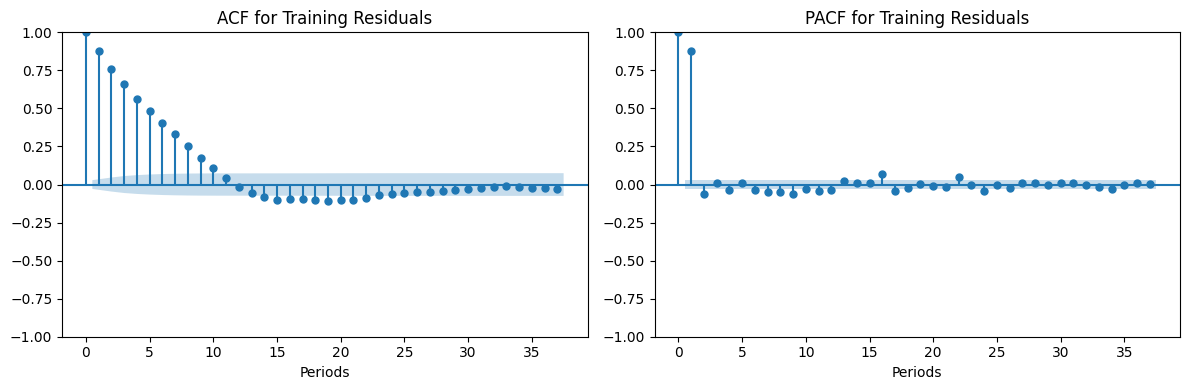

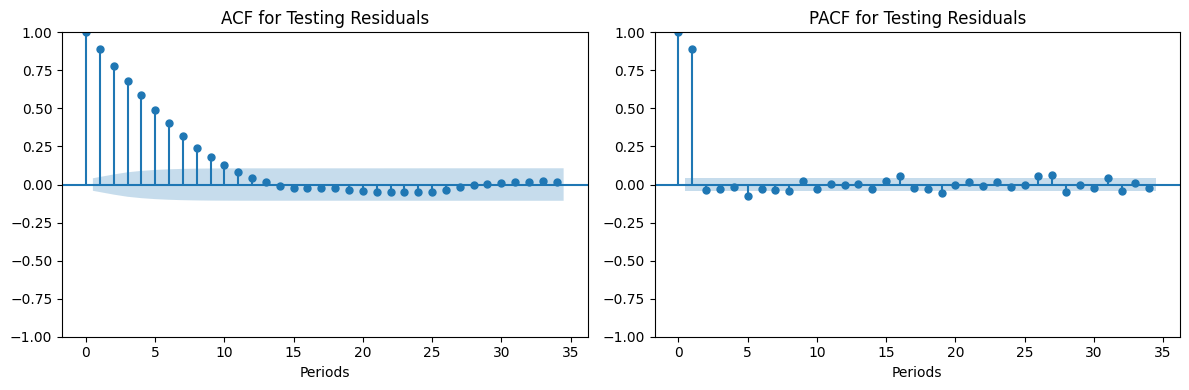

In [19]:
# Calculate residuals
train_residuals = trainY_.flatten() - trainPredict.flatten()
test_residuals = testY_.flatten() - testPredict.flatten()

# Plot ACF of training residuals
plt.figure(figsize=(12, 4))
plt.subplot(121)
sgt.plot_acf(train_residuals, ax=plt.gca(), title='ACF for Training Residuals')
plt.xlabel('Periods')

# Plot PACF of training residuals
plt.subplot(122)
sgt.plot_pacf(train_residuals, ax=plt.gca(), title='PACF for Training Residuals')
plt.xlabel('Periods')
plt.tight_layout()
plt.show()

# Plot ACF of testing residuals
plt.figure(figsize=(12, 4))
plt.subplot(121)
sgt.plot_acf(test_residuals, ax=plt.gca(), title='ACF for Testing Residuals')
plt.xlabel('Periods')

# Plot PACF of testing residuals
plt.subplot(122)
sgt.plot_pacf(test_residuals, ax=plt.gca(), title='PACF for Testing Residuals')
plt.xlabel('Periods')
plt.tight_layout()
plt.show()

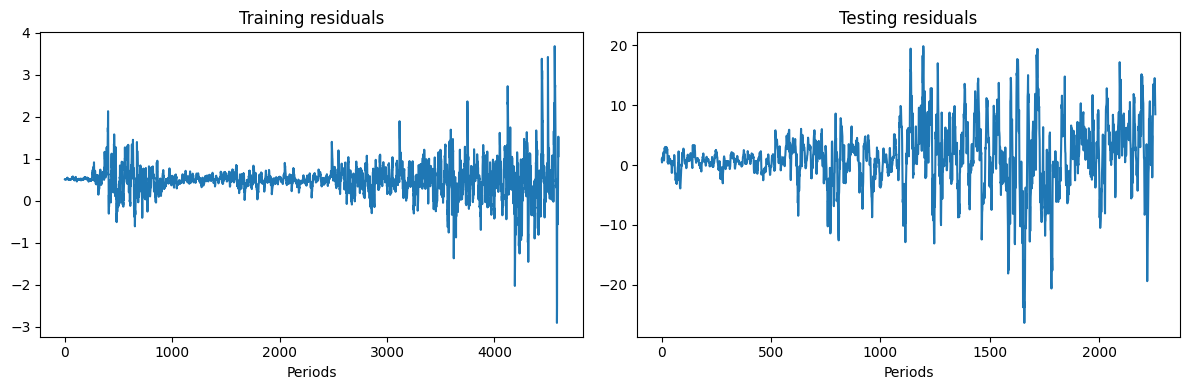

In [20]:
# Training residuals
plt.figure(figsize=(12, 4))
plt.subplot(121, title='Training residuals')
plt.plot(train_residuals)
plt.xlabel('Periods')

# Testing residuals
plt.subplot(122, title='Testing residuals')
plt.plot(test_residuals)
plt.xlabel('Periods')
plt.tight_layout()
plt.show()

In [21]:
from statsmodels.stats import stattools

print(stattools.jarque_bera(train_residuals))
print(stattools.jarque_bera(test_residuals))

(27049.58261613185, 0.0, 0.4670488789246387, 14.845552131839774)
(913.6154321390152, 4.0825322128688714e-199, -0.37922270288979165, 6.022493158616176)


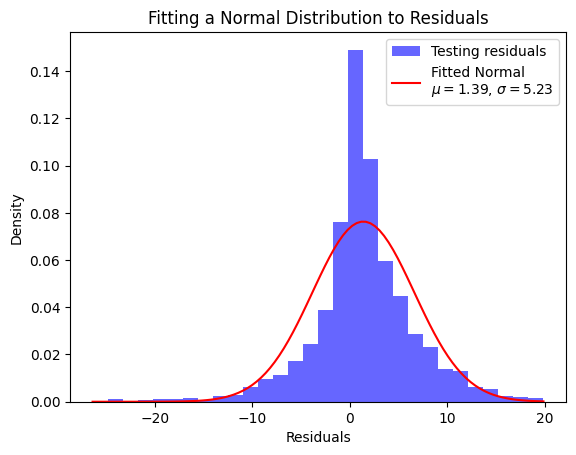

Kolmogorov-Smirnov Test:
Statistic: 0.0947683913650128, p-value: 4.223168040576232e-18


In [22]:
from scipy.stats import norm, kstest

# Step 1: Fit the normal distribution
mu, sigma = norm.fit(test_residuals)

# Step 2: Generate the fitted normal distribution
x = np.linspace(min(test_residuals), max(test_residuals), 100)
pdf = norm.pdf(x, loc=mu, scale=sigma)

# Step 3: Plot the histogram and fitted distribution
plt.hist(test_residuals, bins=30, density=True, alpha=0.6, color='blue', label='Testing residuals')
plt.plot(x, pdf, 'r-', label=f'Fitted Normal\n$\mu={mu:.2f}$, $\sigma={sigma:.2f}$')
plt.title("Fitting a Normal Distribution to Residuals")
plt.xlabel("Residuals")
plt.ylabel("Density")
plt.legend()
plt.show()

# Step 4: Goodness-of-fit test
kstest_result = kstest(test_residuals, 'norm', args=(mu, sigma))
print(f"Kolmogorov-Smirnov Test:\nStatistic: {kstest_result.statistic}, p-value: {kstest_result.pvalue}")

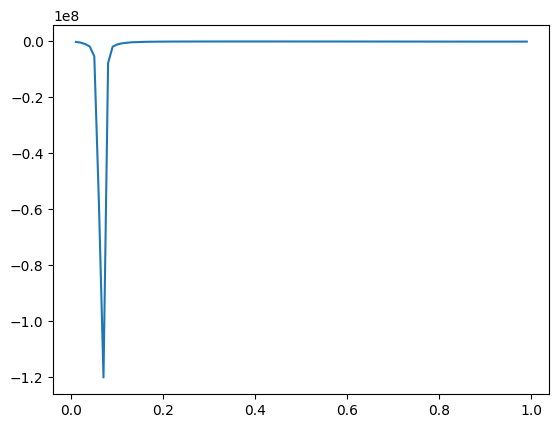

In [23]:
q = 0.97
def optim_datasize(q):
    alpha = (norm.ppf(q)*sigma + mu) * np.sqrt(test_size)
    desired_quantile = np.quantile(train_residuals, q)
    desired_data_size = (alpha / desired_quantile)**2 /(1-sigma)
    return desired_data_size

q = [i/100 for i in range(100)]
plt.plot(q, optim_datasize(q))
# plt.yscale('log')
plt.show()